---

In [1]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")

import torch
import numpy as np
import matplotlib.pyplot as plt

import pickle
from smc.prior import M71Prior

from utils.misc import select_cuda_device

device = select_cuda_device()

Selected device 6, which has 10820 MB available.


### Load in ground truth

In [2]:
images = torch.load("../data/images.pt").to(device)
unpruned_counts = torch.load("../data/unpruned_counts.pt").to(device)
pruned_counts = torch.load("../data/pruned_counts.pt").to(device)
unpruned_fluxes = torch.load("../data/unpruned_fluxes.pt").to(device)
pruned_fluxes = torch.load("../data/pruned_fluxes.pt").to(device)

### Load in SMC results from repeated runs

In [3]:
num_images = images.shape[0]
num_catalogs_per_count = [2500, 5000, 10000]
num_mh_iters = [50, 100, 150]
num_runs = 100
max_objects = 6

In [4]:
runtime = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)
num_iters = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)
log_norm_const = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs, max_objects + 1)
total_intrinsic_flux = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)

for i in range(num_images):
    for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
            runtime[i,c,m] = torch.load(f'smc/runtime_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            num_iters[i,c,m] = torch.load(f'smc/num_iters_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            log_norm_const[i,c,m] = torch.load(f'smc/log_norm_const_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            total_intrinsic_flux[i,c,m] = torch.load(f'smc/total_intrinsic_flux_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt').mean(-1)

### Plot attributes

In [5]:
smc_color = "steelblue"

bigfont = 20
mediumfont = 16
smallfont = 14

mh_colors = ['cadetblue', 'darkorange', 'rebeccapurple']
mh_markers = ['s', 'o', 'D']

ms = 6
elinewidth = 3
capsize = 6
capthick = 3

---

In [6]:
log_norm_const_estimate = log_norm_const.median(-2).values
log_norm_const_lower = log_norm_const.quantile(0.05, dim = -2)
log_norm_const_upper = log_norm_const.quantile(0.95, dim = -2)

In [7]:
with open("../../m71_manyimages/data/params.pkl", "rb") as f:
    params = pickle.load(f)

tile_dim = 8
pad = 1

prior = M71Prior(
    max_objects=6,
    counts_rate=params["counts_rate"] * ((tile_dim + 2 * pad) ** 2) / (tile_dim**2),
    image_height=tile_dim,
    image_width=tile_dim,
    flux_alpha=params["flux_alpha"],
    flux_lower=params["flux_lower"],
    flux_upper=params["flux_upper"],
    pad=pad,
)

In [8]:
prior_count_log_probs = prior.count_prior.log_prob(torch.arange(prior.num_counts))

countprob_estimate = (prior_count_log_probs + log_norm_const).softmax(-1).median(-2).values
countprob_lower = (prior_count_log_probs + log_norm_const).softmax(-1).quantile(0.05, dim = -2)
countprob_upper = (prior_count_log_probs + log_norm_const).softmax(-1).quantile(0.95, dim = -2)

---

### Estimated marginal loglikelihood for the image with one source

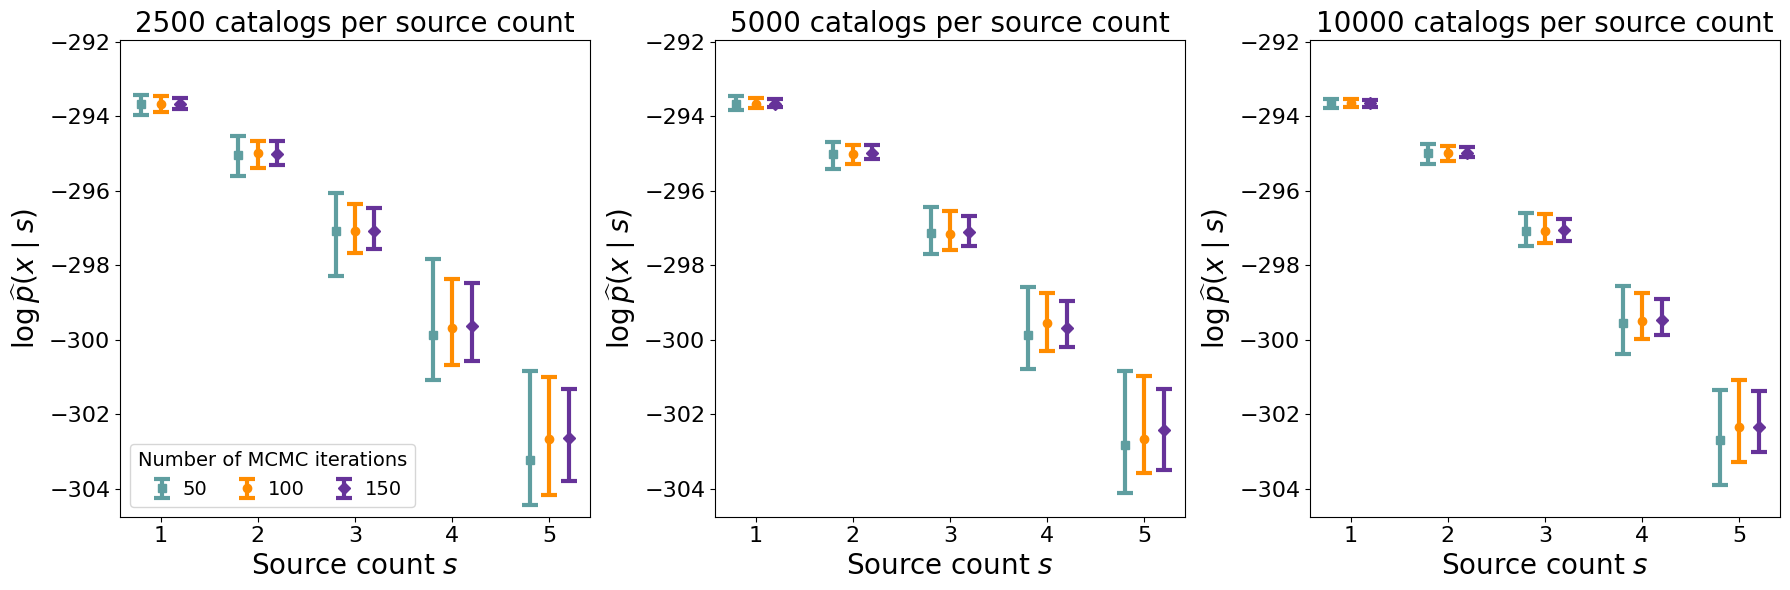

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 0

count_index = log_norm_const_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = log_norm_const_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                   y = median,
                                   yerr = [median - log_norm_const_lower[i,c,m][count_index].numpy(),
                                           log_norm_const_upper[i,c,m][count_index].numpy() - median],
                                   linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                   ms = ms, elinewidth = elinewidth, capsize = capsize, capthick = capthick)
                _ = ax[c].set_ylim(1.001 * log_norm_const_lower[i,...,count_index].min(),
                                   0.995 * log_norm_const_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\log \\widehat{p}(x \mid s)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations", loc = 'lower left',
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/m71synthetic_repeatedruns_logpx1.png', dpi = 250, transparent = True)

---

### Posterior count probabilities for the image with one source

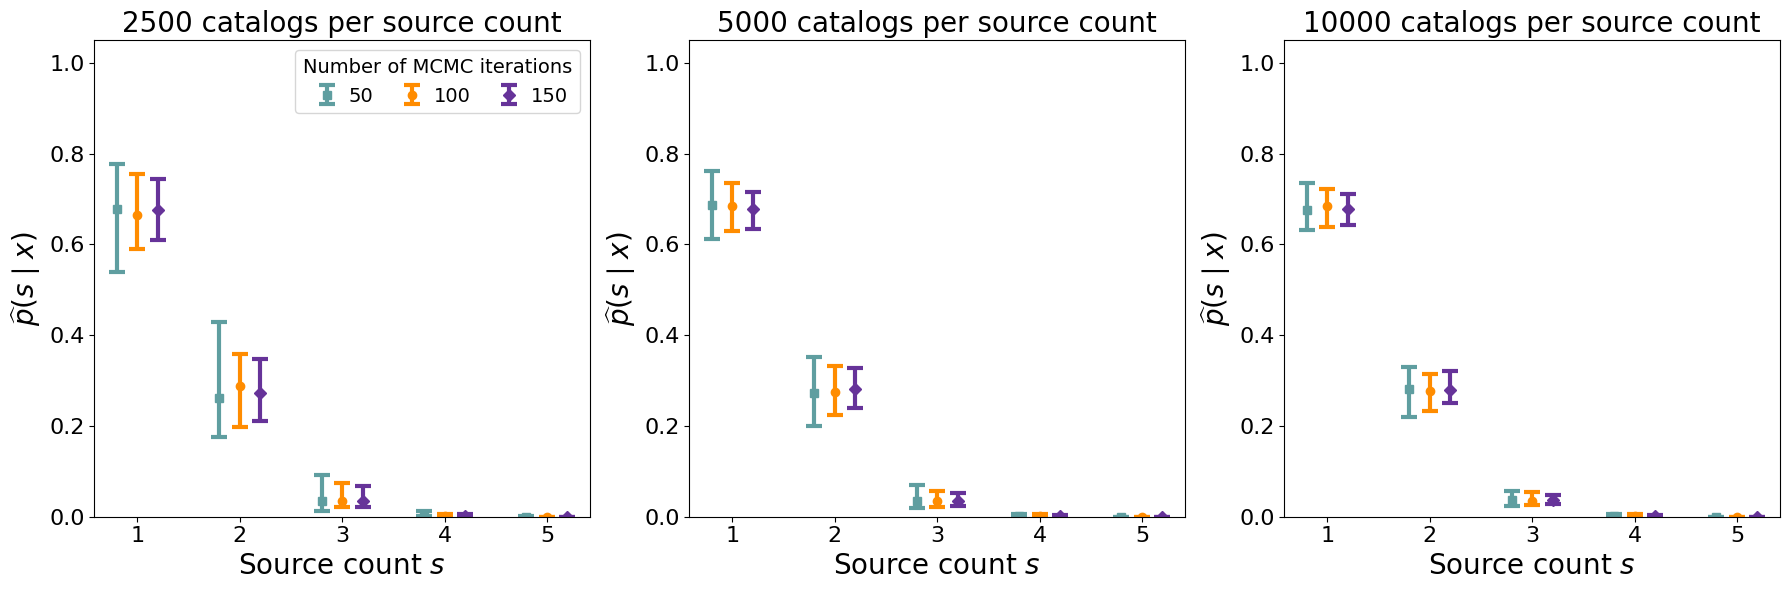

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 0

count_index = countprob_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = countprob_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                y = median,
                                yerr = [median - countprob_lower[i,c,m][count_index].numpy(),
                                        countprob_upper[i,c,m][count_index].numpy() - median],
                                linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                ms = ms, elinewidth = elinewidth, capsize = capsize, capthick = capthick)
                _ = ax[c].set_ylim(0, 1.05)
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\widehat{p}(s \mid x)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations", loc = 'upper right',
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/m71synthetic_repeatedruns_countprob1.png', dpi = 250, transparent = True)

---

### Estimated marginal loglikelihood for the image with four sources

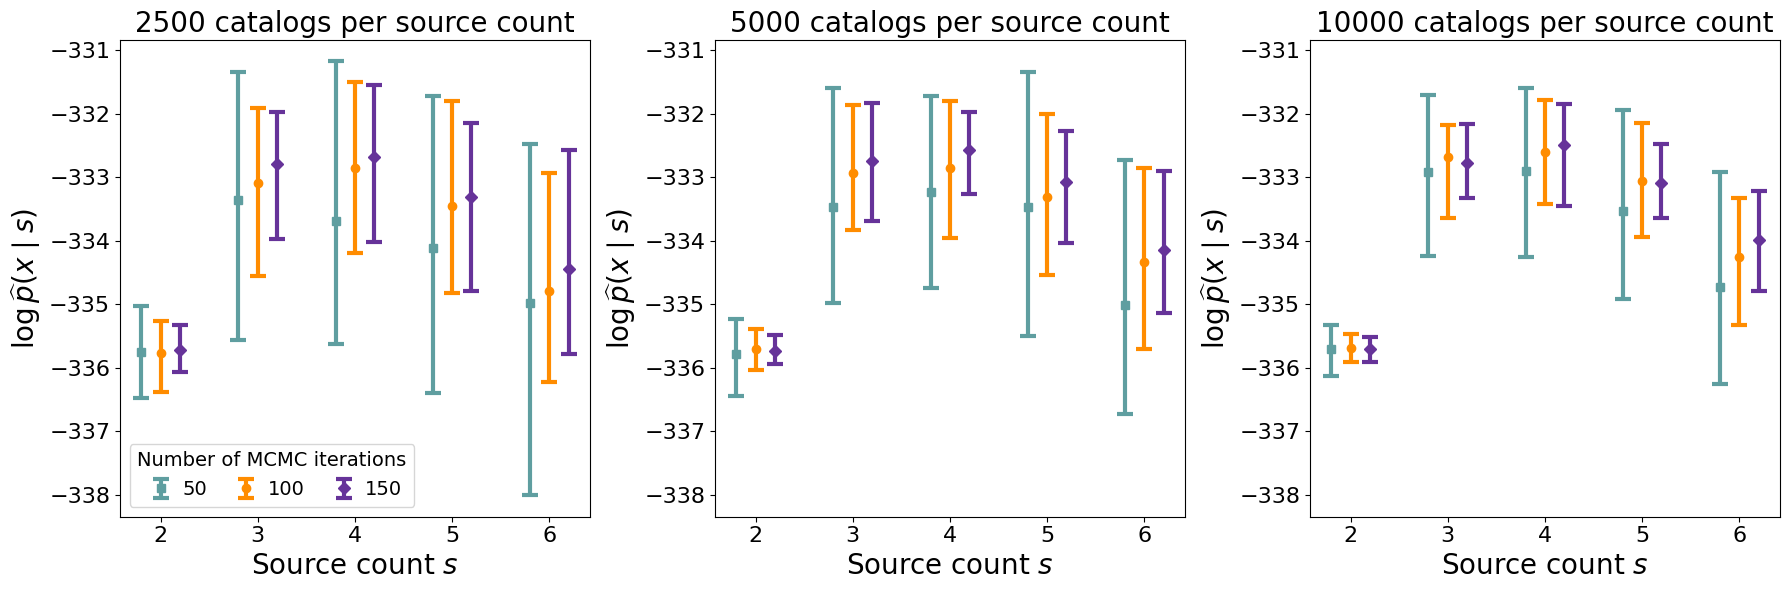

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 1

count_index = log_norm_const_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = log_norm_const_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                   y = median,
                                   yerr = [median - log_norm_const_lower[i,c,m][count_index].numpy(),
                                           log_norm_const_upper[i,c,m][count_index].numpy() - median],
                                   linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                   ms = ms, elinewidth = elinewidth, capsize = capsize, capthick = capthick)
                _ = ax[c].set_ylim(1.001 * log_norm_const_lower[i,...,count_index].min(),
                                   0.999 * log_norm_const_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\log \\widehat{p}(x \mid s)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations", loc = 'lower left',
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/m71synthetic_repeatedruns_logpx2.png', dpi = 250, transparent = True)

---

### Posterior count probabilities for the image with four sources

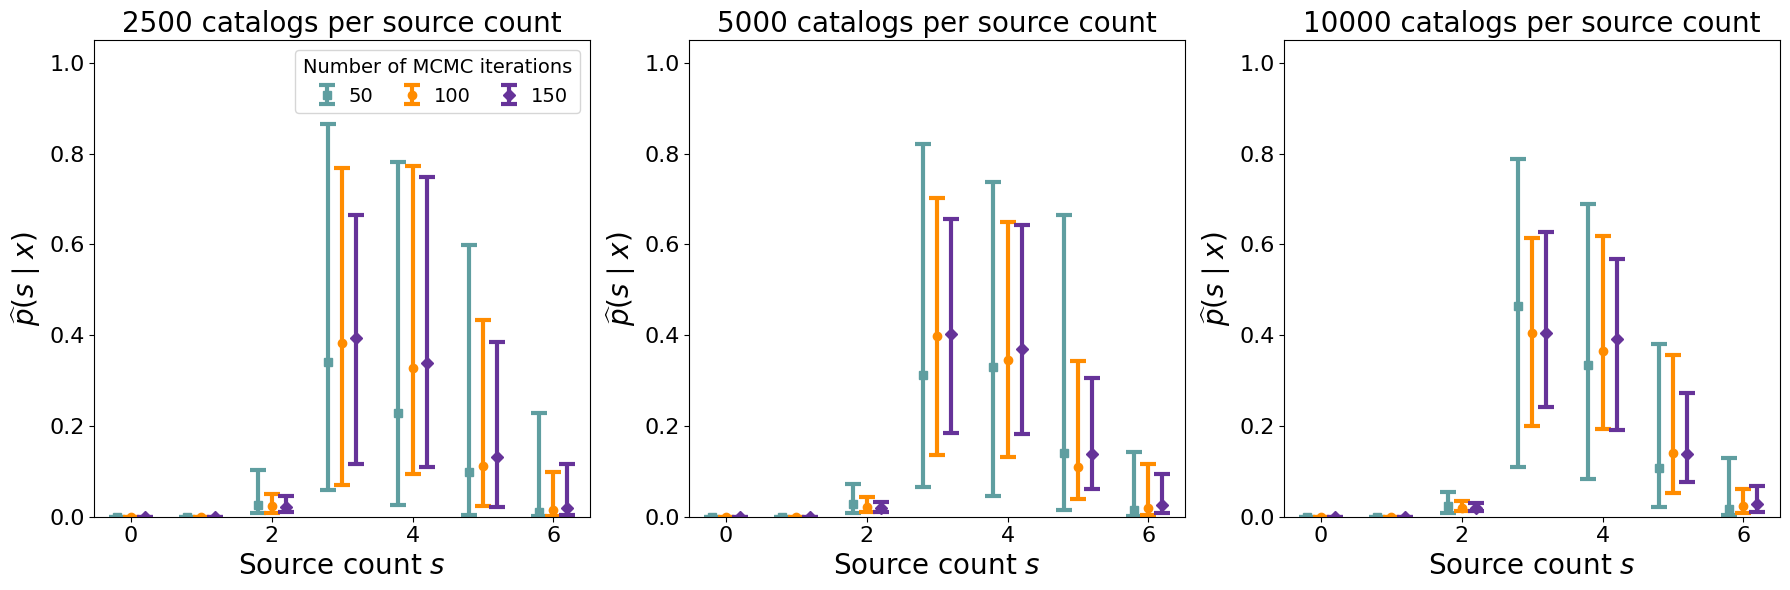

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 1

count_index = countprob_estimate[i,-1,-1].sort().indices[:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = countprob_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                y = median,
                                yerr = [median - countprob_lower[i,c,m][count_index].numpy(),
                                        countprob_upper[i,c,m][count_index].numpy() - median],
                                linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                ms = ms, elinewidth = elinewidth, capsize = capsize, capthick = capthick)
                _ = ax[c].set_ylim(0, 1.05)
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\widehat{p}(s \mid x)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations", loc = 'upper right',
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/m71synthetic_repeatedruns_countprob2.png', dpi = 250, transparent = True)

---